# Read the various Urban Atlas maps and output a single raster

**Inputs:**
* Any number of Urban Atlas vector data sets as shapefiles

**Output:**
* Single raster map containing the combined data
* Ideally also combine this with Corine map, in the gaps between the UA maps, but that may be more complicated if the pixel values are different

**Process:**
* List the shapefiles want to include
* Open and concatenate them, checking the CRS match
* Convert to Corine pixel values
* Convert to raster and output
* Combine output with corine, perhap s using coprine as an input and overwriting where features exist in UA


The codes are defined [here](https://land.copernicus.eu/user-corner/technical-library/urban-atlas-2012-mapping-guide-new) (p11)

We are interested in anything matching 11???  (1,2 in Corine)

Other urban comes under 12??? (3-6)

Construction and mining is 13??? (7-9)

Green urban areas are 14??? (10-11)

Farmland is 2???? (12-22)

Natural vegetation is 3???? (23-36)

Wetlands are 40000 (37-39)

Water is 50000 (40-44,50)

No data is 90000 (48-49,255)



In [116]:
"""Initialization"""
import os
import glob
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import rasterize

from process.common import raster_utils as ru
from process.common import geoplot as gpl

%matplotlib inline

rootdir='/Users/nathan.bourne/data/thermcert/'
uadir = rootdir+'copernicus/urban_atlas/'
corine_file = rootdir+'copernicus/land_cover/g100_clc12_V18_5.tif'


## First combine all the UA data and rasterize

In [106]:
shapefiles = glob.glob(uadir+'*/Shapefiles/*UA2012.shp')
print(shapefiles)

['/Users/nathan.bourne/data/thermcert/copernicus/urban_atlas/UK002L3_WEST_MIDLANDS_URBAN_AREA/Shapefiles/UK002L3_WEST_MIDLANDS_URBAN_AREA_UA2012.shp', '/Users/nathan.bourne/data/thermcert/copernicus/urban_atlas/UK010L3_SHEFFIELD/Shapefiles/UK010L3_SHEFFIELD_UA2012.shp', '/Users/nathan.bourne/data/thermcert/copernicus/urban_atlas/UK518L1_DERBY/Shapefiles/UK518L1_DERBY_UA2012.shp', '/Users/nathan.bourne/data/thermcert/copernicus/urban_atlas/UK029L1_NOTTINGHAM/Shapefiles/UK029L1_NOTTINGHAM_UA2012.shp', '/Users/nathan.bourne/data/thermcert/copernicus/urban_atlas/UK027L1_STOKE_ON_TRENT/Shapefiles/UK027L1_STOKE_ON_TRENT_UA2012.shp', '/Users/nathan.bourne/data/thermcert/copernicus/urban_atlas/UK008L3_GREATER_MANCHESTER/Shapefiles/UK008L3_GREATER_MANCHESTER_UA2012.shp']


In [107]:
uadata = []
for sf in shapefiles:
    uadata += [gpd.read_file(sf)]
    print(len(uadata[-1]))
    if len(uadata)>1:
        assert uadata[-1].crs == uadata[-2].crs
uadata = pd.concat(uadata,sort=False)


50832
27307
12830
18261
17659
71904


In [108]:
print(len(uadata))

198793


In [109]:
crs_uadata = uadata.crs

In [110]:
valid = np.isfinite(uadata['CODE2012'].astype(np.float))

In [111]:
def map_ua_corine(uacode):
    ua = (111,112,113,121,122,123,124,131,132,133,134,141,142,  
           21, 22, 23, 24, 25, 31, 32, 33, 40, 50,  9)
    co = (1,  2,  2,  3,  4,  5,  6,  7,  8,  9,  9,  10, 11,  
           12, 13, 18, 20, 16, 25, 26, 32, 37, 41, 48 )
    for ii in range(len(ua)):
        if str(uacode).find(str(ua[ii]))==0:
            return co[ii]
    return 255
    


    

In [112]:
uacodes = uadata['CODE2012'].values.astype(np.str)
cocodes = np.array([map_ua_corine(ua) for ua in uacodes])


In [ ]:
for ii in range(len(cocodes)):
    print(uacodes[ii],cocodes[ii])

In [113]:
uadata = uadata.assign(CORINECODE = cocodes)

(<matplotlib.axes._subplots.AxesSubplot at 0x12fdcd470>, (1.0, 48.0))

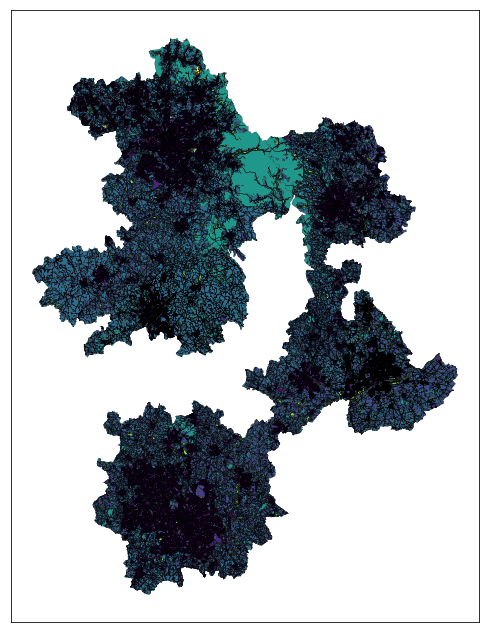

In [52]:

fig,ax = gpl.make_figure()
gpl.choropleth(ax,uadata[valid],colname='CORINECODE',colormap='viridis')


In [114]:
bounds = uadata.total_bounds
shape_in_m = bounds[3]-bounds[1],bounds[2]-bounds[0]
print(bounds)
print(shape_in_m)

[3471210.1037 3308414.1748 3597728.3719 3473664.0244]
(165249.8496000003, 126518.26819999889)


In [115]:
height,width = shape_in_m[0]/10.0, shape_in_m[1]/10.0
trans_uadata = rasterio.transform.from_bounds(*bounds, width,height)
print(height,width)
print(trans_uadata)


16524.98496000003 12651.82681999989
| 10.00, 0.00, 3471210.10|
| 0.00,-10.00, 3473664.02|
| 0.00, 0.00, 1.00|


In [108]:
rst_shape=tuple(np.ceil([height,width]).astype(np.int))
print(rst_shape)
what = zip(uadata['geometry'].values,uadata['CORINECODE'].values)
rst_uadata = rasterize(what,
                       transform=trans_uadata,
                       fill=255,
                       out_shape=rst_shape,
                       dtype=rasterio.uint8
                      )

(16525, 12652)


(<matplotlib.axes._subplots.AxesSubplot at 0xd506dcba8>,
 <matplotlib.colors.Normalize at 0xd506f9b70>)

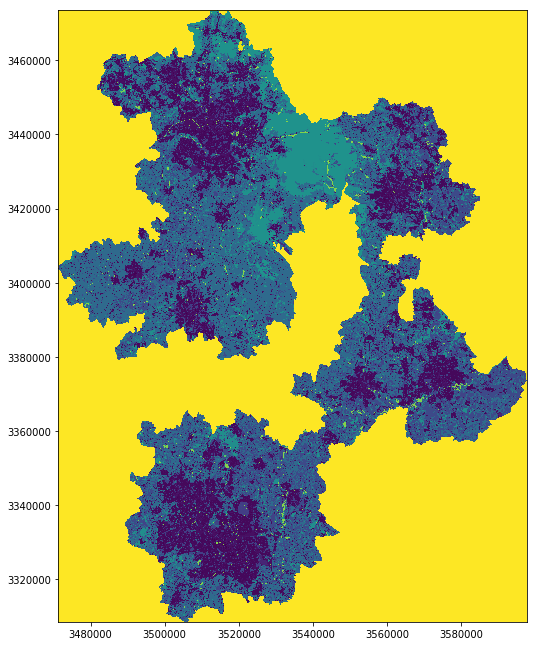

In [122]:
fig,ax = gpl.make_figure()
gpl.raster(ax, rst_uadata.astype(np.float), 
           transform=trans_uadata,
           no_axes_ticks=False, colormap='viridis', vmax=50,
           use_rst_plot=True)

In [120]:
rst_uadata.shape

(16525, 12652)

In [121]:
# Let's test whether any error is introduced by the choice of 
# shape: does the result look the same if we change the shape?
rst_shape1=tuple(np.ceil([height,width*1.2]).astype(np.int))
print(rst_shape1)
what = zip(uadata['geometry'].values,uadata['CORINECODE'].values)
rst_uadata1 = rasterize(what,
                       transform=trans_uadata,
                       fill=255,
                       out_shape=rst_shape1,
                       dtype=rasterio.uint8
                      )

(16525, 15183)


(<matplotlib.axes._subplots.AxesSubplot at 0xd50759fd0>,
 <matplotlib.colors.Normalize at 0xd50738908>)

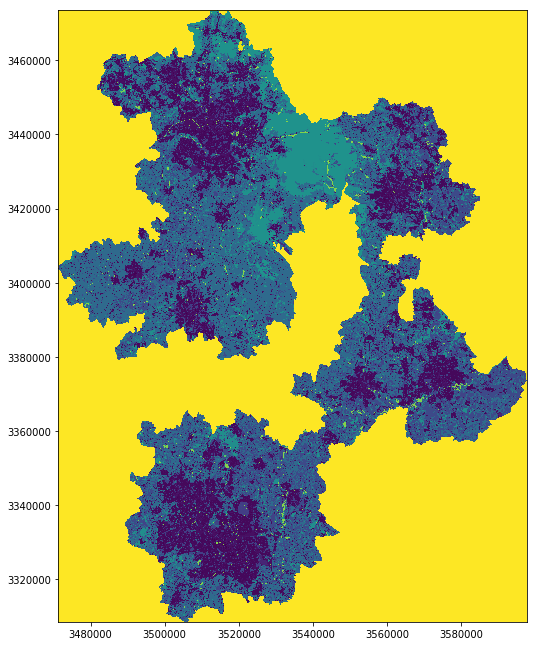

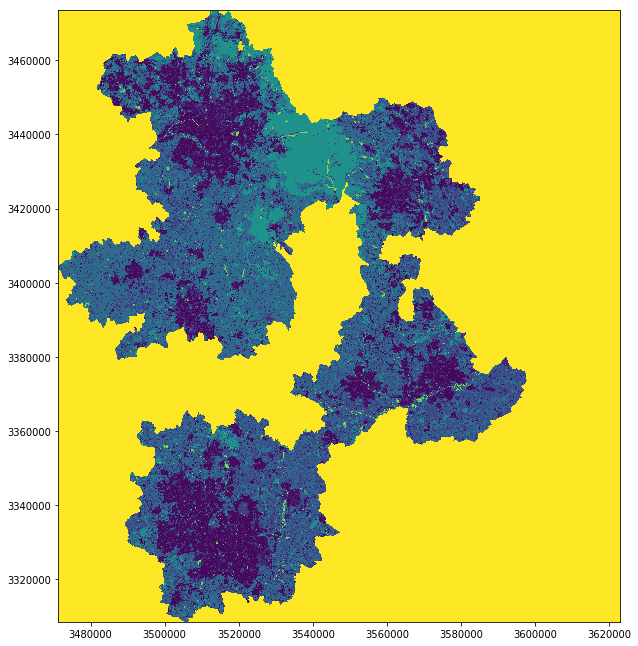

In [123]:
fig,ax = gpl.make_figure()
gpl.raster(ax, rst_uadata.astype(np.float), 
           transform=trans_uadata,
           no_axes_ticks=False, colormap='viridis', vmax=50,
           use_rst_plot=True)
fig,ax = gpl.make_figure()
gpl.raster(ax, rst_uadata1.astype(np.float), 
           transform=trans_uadata,
           no_axes_ticks=False, colormap='viridis', vmax=50,
           use_rst_plot=True)

In [135]:
# Output data
filename = uadir + 'Five_Counties_UA.tif'
with rasterio.Env():
    profile = {'driver': 'GTiff', 
               'nodata': 255, 
               'width': rst_shape[1],
               'height': rst_shape[0], 
               'count': 1,
               'dtype': rasterio.uint8,
               'crs': crs_uadata,
               'transform': trans_uadata,
               'blockxsize': 128, 
               'blockysize': 128, 
               'tiled': True, 
               'compress': 'lzw', 
               'interleave': 'band'}
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(rst_uadata,1)

(16525, 12652)


(<matplotlib.axes._subplots.AxesSubplot at 0xd421a26a0>,
 <matplotlib.colors.Normalize at 0xd4220b860>)

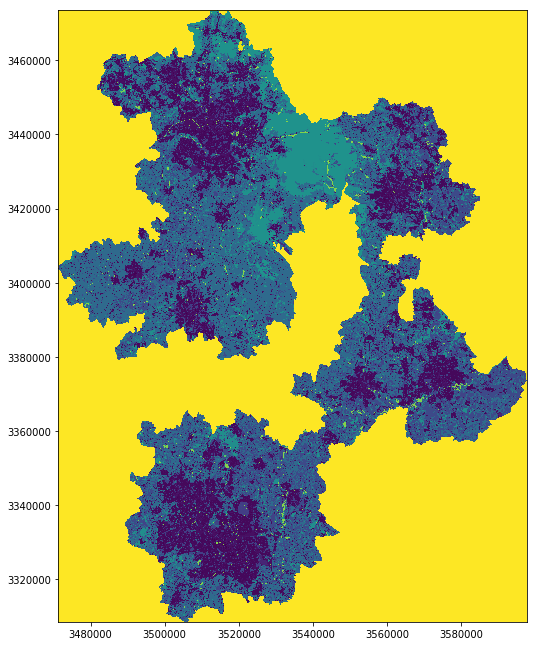

In [142]:
# Confirm output can be read with correct transform
with rasterio.open(filename,'r') as src :   
    imdata = src.read()[0,:,:]
    trans_imdata=ru.rst_transform(src)
print(imdata.shape)
fig,ax = gpl.make_figure()
gpl.raster(ax, imdata.astype(np.float), 
           transform=trans_imdata,
           no_axes_ticks=False, colormap='viridis', vmax=50,
           use_rst_plot=True)


## Now attempt to combine with Corine

In [23]:
with rasterio.open(corine_file,'r') as src:
    profile_co = src.profile
    crs_co = src.crs
    trans_codata = ru.rst_transform(src)
#     rst_codata = src.read()[0,:,:] 
print(profile_co)
print(crs_co)
# print(rst_codata.shape)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 127480, 'height': 85900, 'count': 1, 'crs': CRS({'init': 'epsg:3035'}), 'transform': Affine(100.0, 0.0, -2700000.0,
       0.0, -100.0, 5500000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
+init=epsg:3035


In [132]:
# Only open a window on England

AoIr0,AoIc0 = 17700,58000
AoIr1,AoIc1 = 24500,65000
AoIh,AoIw = AoIr1 - AoIr0, AoIc1 - AoIc0
AoI_window = rasterio.windows.Window(AoIc0,AoIr0,AoIw,AoIh)
print(AoI_window)
with rasterio.open(corine_file,'r') as src:
#     rst_codata = np.empty(shape=(1,AoIh//10,AoIw//10),dtype=np.uint8)
#     src.read(window=AoI_window,out=rst_codata)
    rst_codata = src.read(window=AoI_window)
    wtran = src.window_transform(AoI_window)

print(rst_codata.shape)
print(rst_codata.min(),rst_codata.max())


Window(col_off=58000, row_off=17700, width=7000, height=6800)
(1, 6800, 7000)
1 255


(1, 6800, 7000)


(<matplotlib.axes._subplots.AxesSubplot at 0xd598c4208>,
 <matplotlib.colors.Normalize at 0xd598d8d30>)

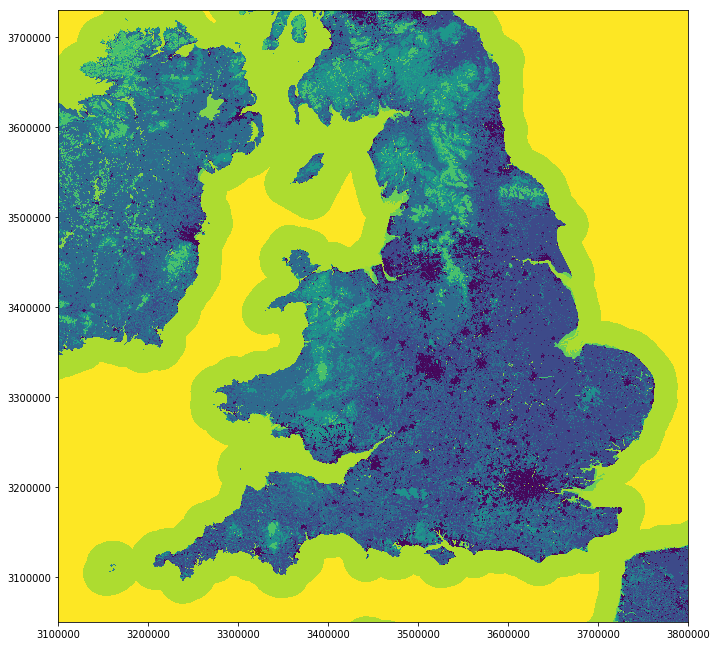

In [127]:
print(rst_codata.shape)
fig,ax = gpl.make_figure()
gpl.raster(ax, rst_codata.astype(np.float)[0,:,:], 
           transform=wtran,
           no_axes_ticks=False, colormap='viridis', vmax=50,
           use_rst_plot=True)


In [117]:
plt.close('all')

## Now rasterize the UA data but use Corine as the underlying map where no UA data are present

In [119]:
# Data have to be in same CRS
uadata = uadata.to_crs(crs_co)

In [141]:
# The Corine data must be upsampled from 100m to 10m resolution
from rasterio.warp import Affine, reproject, Resampling

print(wtran)
hr_wtran = Affine(wtran.a/10.0, wtran.b, wtran.c,
                wtran.d, wtran.e/10.0, wtran.f)
print(hr_wtran)

rst_co_uadata = np.empty(shape=(rst_codata.shape[0],
                                round(rst_codata.shape[1]*10),
                                round(rst_codata.shape[2]*10)),
                         dtype=rst_codata.dtype)
reproject(
    rst_codata, rst_co_uadata,
    src_transform = wtran,
    dst_transform = hr_wtran,
    src_crs = crs_co,
    dst_crs = crs_co,
    resampling = Resampling.nearest)

print(rst_codata.shape)
print(rst_co_uadata.shape)

| 100.00, 0.00, 3100000.00|
| 0.00,-100.00, 3730000.00|
| 0.00, 0.00, 1.00|
| 10.00, 0.00, 3100000.00|
| 0.00,-10.00, 3730000.00|
| 0.00, 0.00, 1.00|
(1, 6800, 7000)
(1, 68000, 70000)


In [142]:
# rasterize the UA features into the new resampled Corine raster
what = zip(uadata['geometry'].values,uadata['CORINECODE'].values)
rst_co_uadata = rasterize(what,
                           transform=hr_wtran,
                           out=rst_co_uadata,
                           dtype=rasterio.uint8
                          )

(1, 68000, 70000)


(<matplotlib.axes._subplots.AxesSubplot at 0xd59775390>,
 <matplotlib.colors.Normalize at 0xd5978c080>)

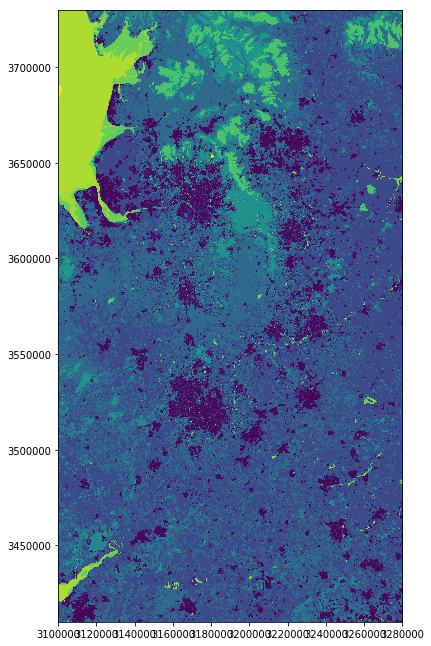

In [144]:
print(rst_co_uadata.shape)
fig,ax = gpl.make_figure()
gpl.raster(ax, rst_co_uadata.astype(np.float)[0,19000:51000,34000:52000], 
           transform=hr_wtran,
           no_axes_ticks=False, colormap='viridis', vmax=50,
           use_rst_plot=True)


In [145]:
# Output data
rst_shape = rst_co_uadata.shape
filename = uadir + 'Five_Counties_UA_Corine.tif'
with rasterio.Env():
    profile = {'driver': 'GTiff', 
               'nodata': 255, 
               'width': rst_shape[2],
               'height': rst_shape[1], 
               'count': 1,
               'dtype': rasterio.uint8,
               'crs': crs_co,
               'transform': hr_wtran,
               'blockxsize': 128, 
               'blockysize': 128, 
               'tiled': True, 
               'compress': 'lzw', 
               'interleave': 'band'}
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(rst_co_uadata[0,:,:],1)